In [33]:
packages <- c(
  "tuneR",      # WAV file processing
  "fda.usc",    # Functional data processing
  "plot3D",     # For 3D plotting
  "mclust",     # For ARI
  "caret"       # For confusion matrix
)

for (package in packages) {
  if (!requireNamespace(package, quietly = TRUE)) {
    install.packages(package)
  }

  library(package, character.only = TRUE)
}
set.seed(42)

### Prepare dataset filepaths

In [34]:
data_dir <- "SpeechCommands"
# When testing is TRUE, validation dataset is used for training
# When testing is FALSE, training dataset is used for training
testing <- TRUE

train_paths <- file.path(data_dir, readLines(file.path(data_dir, "train.txt")))
val_paths <- file.path(data_dir, readLines(file.path(data_dir, "val.txt")))
test_paths <- file.path(data_dir, readLines(file.path(data_dir, "test.txt")))

if (testing) {
  train_paths <- val_paths
} else {
  # Merge test and validation datasets
  test_paths <- c(test_paths, val_paths)
}

sample_count <- data.frame(
  Subset = c("Train", "Test"),
  Utterances = c(length(train_paths), length(test_paths))
)

sample_count

Subset,Utterances
<chr>,<int>
Train,3338
Test,3789


### Load training and testing sets
* Read signal from file
* Center signal
* Create log periodogram
* Interpolate onto a coarser grid
* Create fdata object

In [35]:
load_audio_as_fdata <- function(filepath, func = mean) {
  audio <- tuneR::readWave(filepath)
  signal <- audio@left

  # Center the signal
  signal <- signal - mean(signal)

  pgram <- TSA::periodogram(signal, plot = FALSE)
  log_pgram <- log(pgram$spec + 1e-10)
  freqs <- pgram$freq * audio@samp.rate / 1000

  # Interpolate the log periodogram onto a coarser grid
  reduced_freqs <- seq(min(freqs), max(freqs), length.out = 512)
  log_pgram <- approx(x = freqs, y = log_pgram, xout = reduced_freqs)$y

  fdata_obj <- fda.usc::fdata(
    matrix(log_pgram, nrow = 1),
    argvals = reduced_freqs,
    rangeval = range(reduced_freqs),
    names = list(
      main = "Google Speech Commands",
      xlab = "Frequencies (kHz)",
      ylab = "log(Power)"
    )
  )

  return(fdata_obj)
}

load_dataset <- function(filepaths) {
  fdata_list <- list()
  labels <- c()

  for (filepath in filepaths) {
    # Extract class label from file path
    label <- strsplit(filepath, "/")[[1]][2]

    fdata_list[[filepath]] <- load_audio_as_fdata(filepath)
    labels <- c(labels, label)
  }

  # Convert list of fdata objects to single fdata object
  fdata <- do.call(c, fdata_list)

  # Convert class labels to factor
  labels <- factor(labels, levels = c(
    "zero", "one", "two", "three", "four",
    "five", "six", "seven", "eight", "nine"
  ))

  return(list(data = fdata, labels = labels))
}

train <- load_dataset(train_paths)
test <- load_dataset(test_paths)

class_distribution <- data.frame(
  Class = levels(train$labels),
  Train = as.vector(table(train$labels)),
  Test = as.vector(table(test$labels))
)
cat("Class Distribution Summary\n")
print(class_distribution, row.names = FALSE)

Class Distribution Summary
 Class Train Test
  zero   352  385
   one   315  364
   two   316  384
 three   321  377
  four   347  368
  five   337  408
   six   348  374
 seven   351  376
 eight   318  376
  nine   333  377


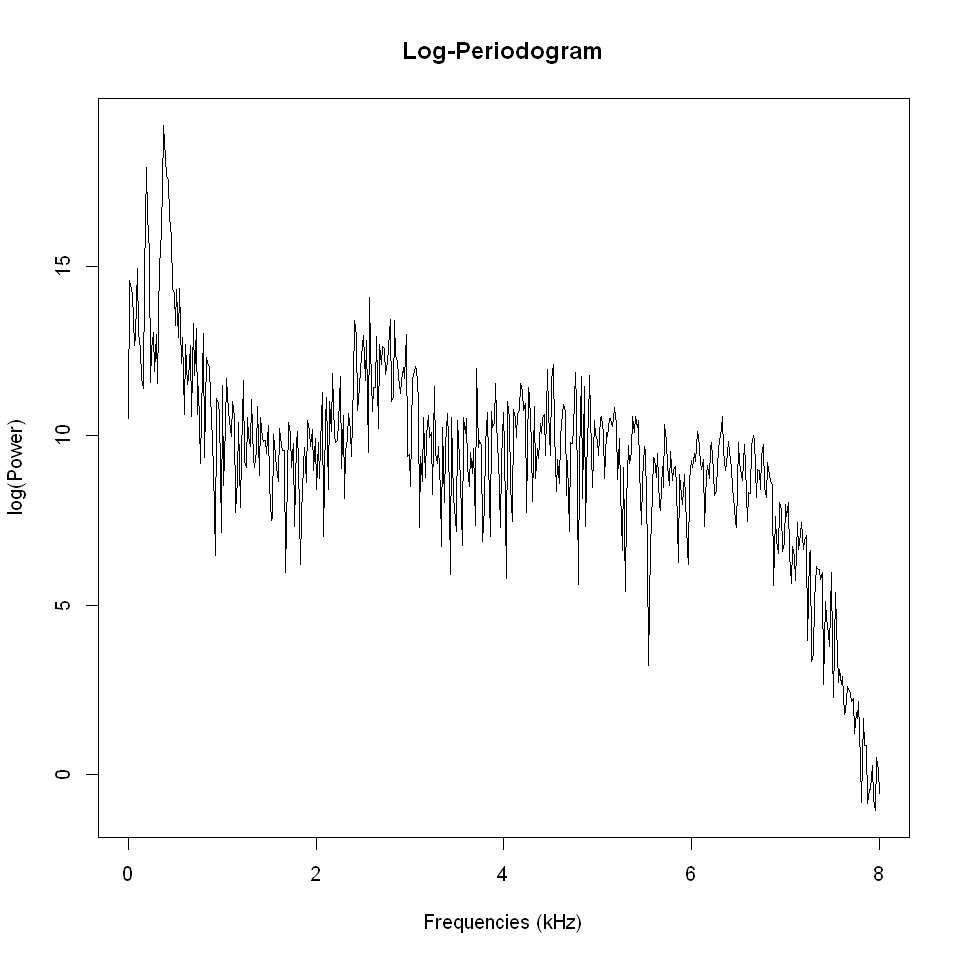

In [36]:
num_samples <- 1
plot(
  train$data[1:num_samples, ],
  main = "Log-Periodogram"
)

### Find optimal smoothing parames with Nadaraya-Watson

Optimal smoothing parameter: 0.03781162

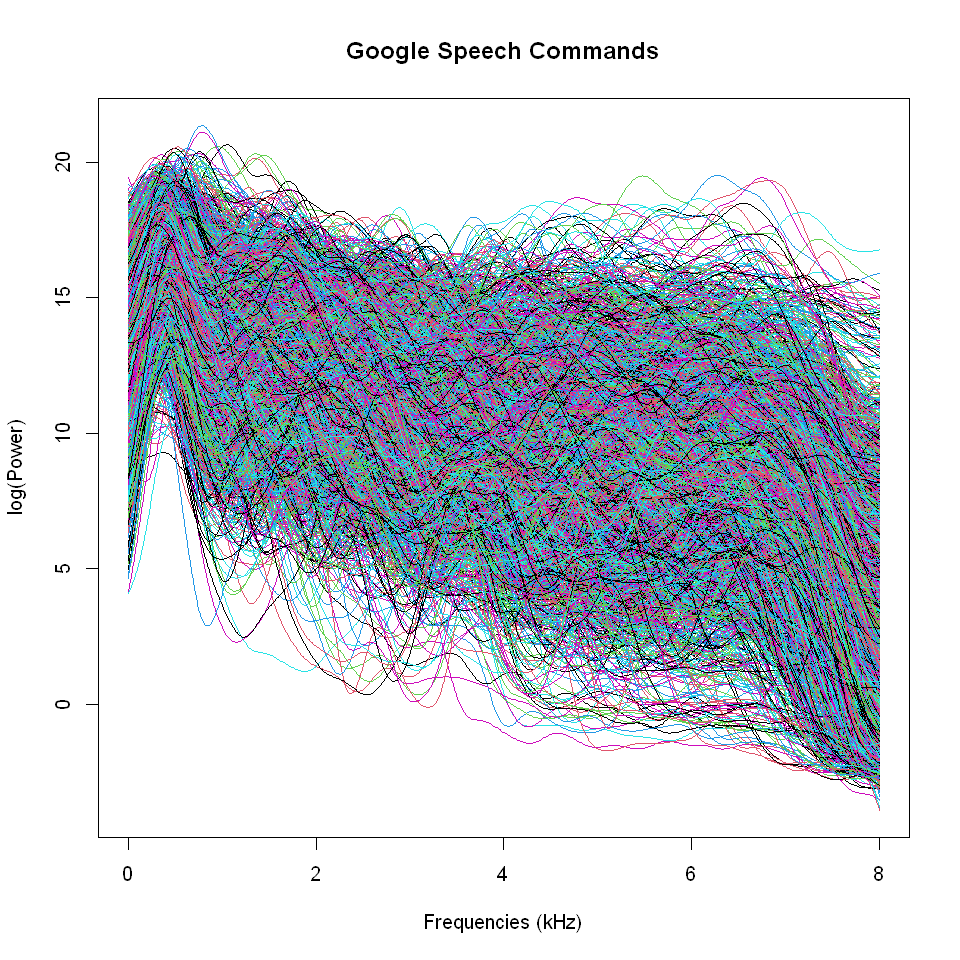

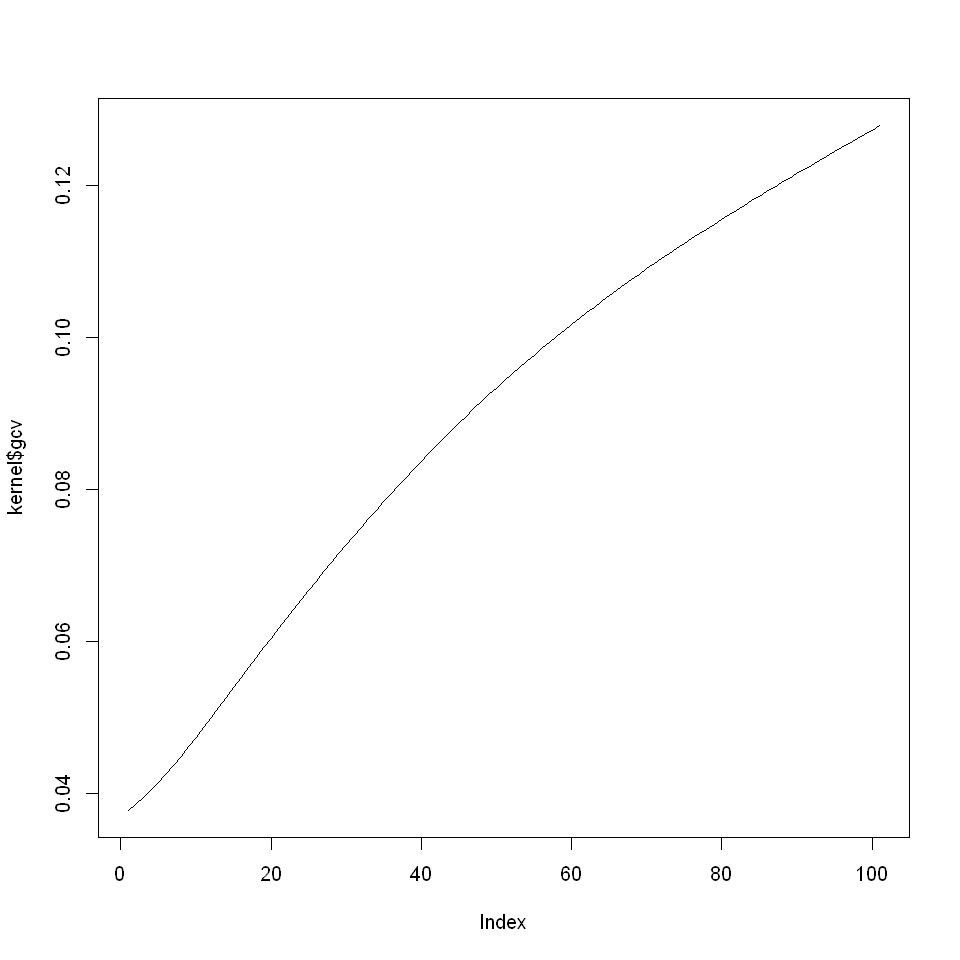

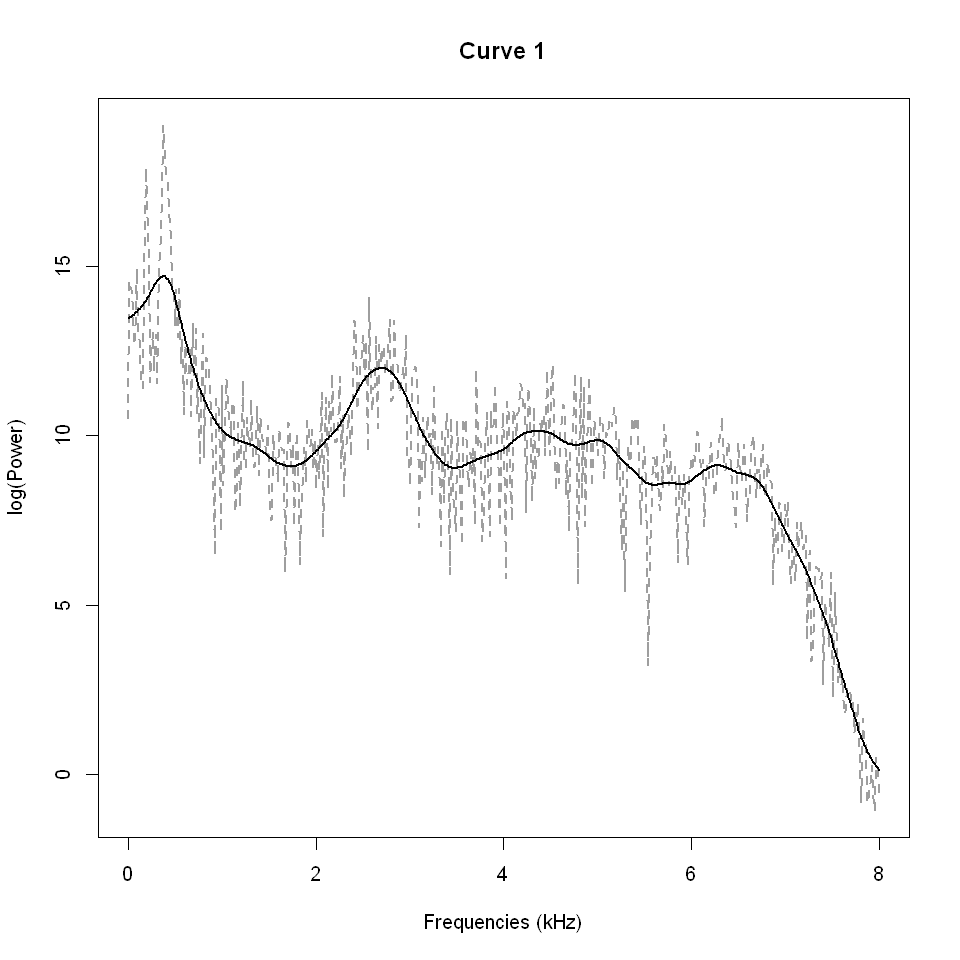

In [37]:
kernel <- fda.usc::optim.np(
  train$data,
  type.S = S.NW,
  par.CV = list(criteria = "GCV")
)
cat("Optimal smoothing parameter:", kernel$gcv.opt)

train$smooth <- kernel$fdata.est
plot(train$smooth)
plot(kernel$gcv, type = "l")

index <- 1
plot(
  train$data[index, ],
  main = "Curve 1",
  lty = 2, lwd = 2, col = 8
)
lines(train$smooth[index, ], col = 1, lty = 1, lwd = 2)

### Apply smoothing to the test set

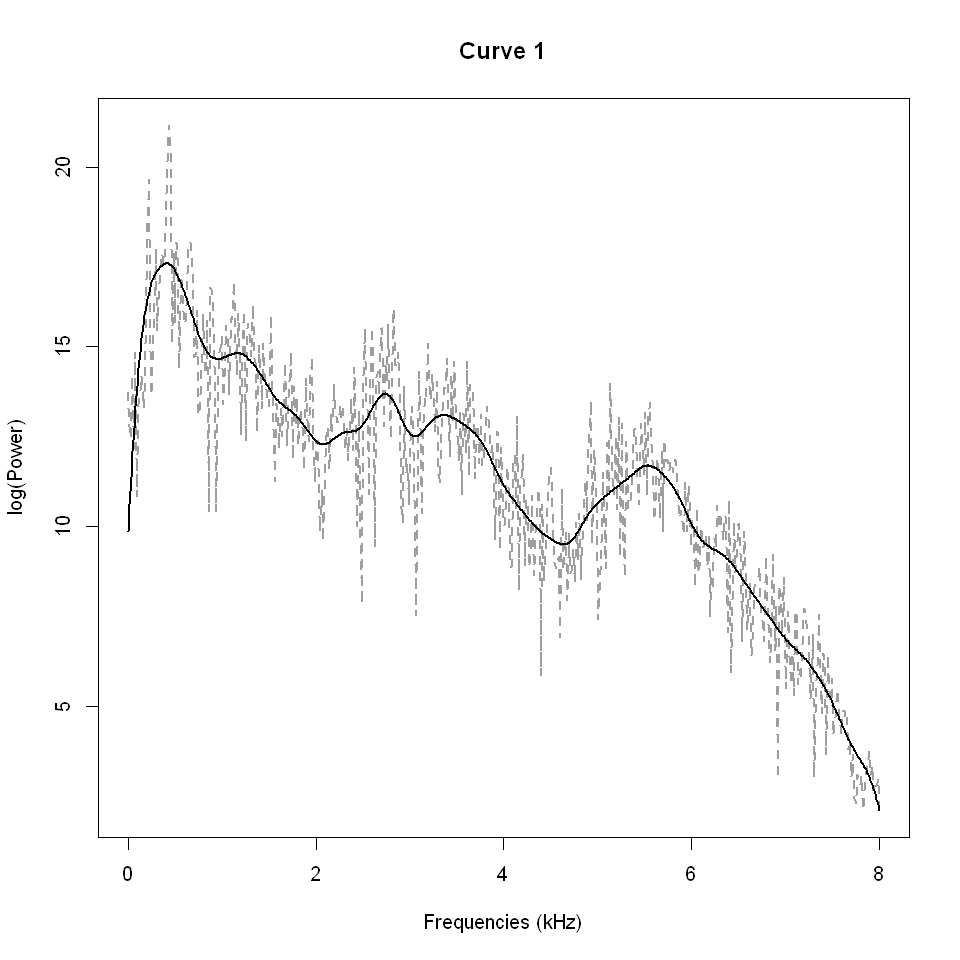

In [38]:
# Create smoothing matrix using the same grid as train data
# Apply the smoothing to the test data
s <- fda.usc::S.NW(test$data$argvals, h = kernel$h.opt)
smoothed_matrix <- test$data$data %*% s
test$smooth <- fda.usc::fdata(
  smoothed_matrix,
  argvals = test$data$argvals,
  rangeval = test$data$rangeval,
  names = test$data$names
)

index <- 1
plot(
  test$data[index, ],
  main = "Curve 1",
  lty = 2, lwd = 2, col = 8
)
lines(test$smooth[index, ], col = 1, lty = 1, lwd = 2)

### Mean curve plots

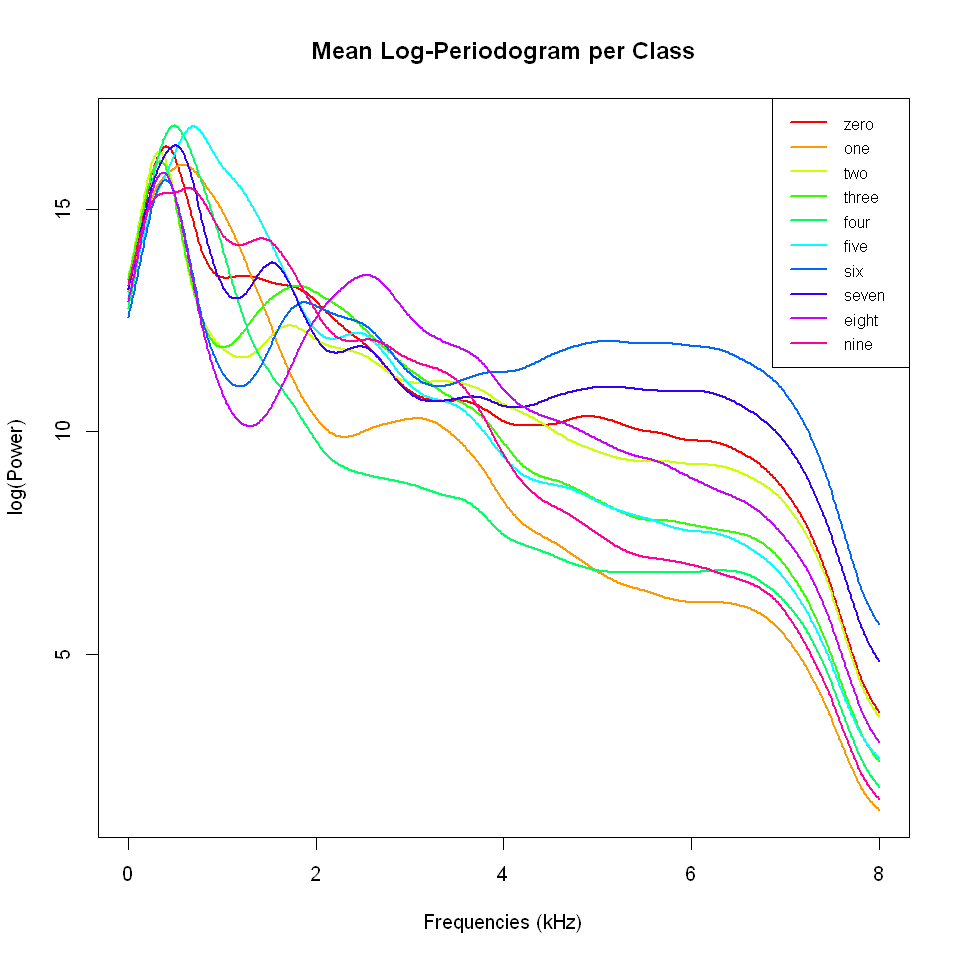

In [39]:
class_labels <- levels(train$labels)
num_classes <- length(class_labels)
palette <- rainbow(num_classes)

# Compute mean curves for each class
mean_curves <- lapply(class_labels, function(label) {
  idx <- which(train$labels == label)
  func.mean(train$smooth[idx, ])
})

# Plot the first mean curve
plot(
  mean_curves[[1]],
  main = "Mean Log-Periodogram per Class",
  col = palette[1],
  lwd = 2,
  # Determine a common y-axis range for all curves
  ylim = range(sapply(mean_curves, function(x) range(x$data)))
)

# Add the rest of the mean curves
for (i in 2:num_classes) {
  lines(mean_curves[[i]], col = palette[i], lwd = 2)
}

# Add legend
legend("topright", legend = class_labels, col = palette, lwd = 2, cex = 0.8)

### Derivative curve plots (velocity and accelaration)

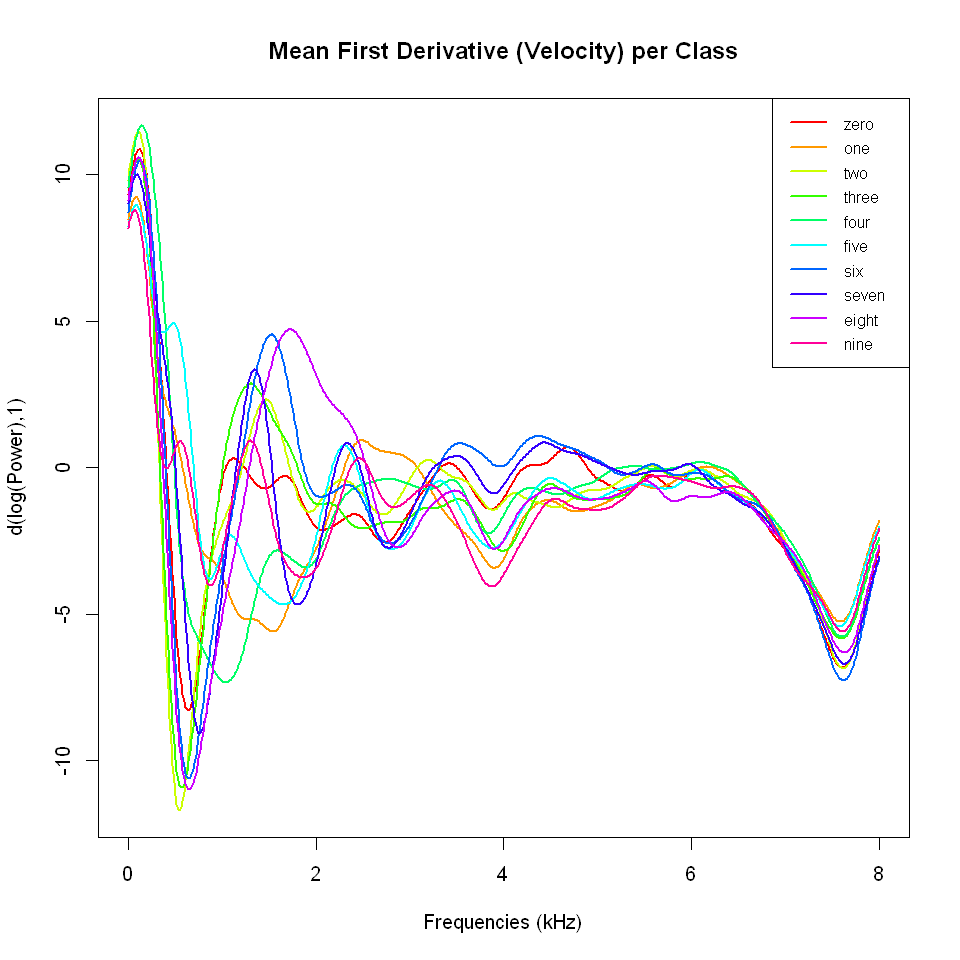

In [40]:
mean_deriv1_curves <- lapply(class_labels, function(label) {
  idx <- which(train$labels == label)
  deriv1 <- fdata.deriv(train$smooth[idx, ], nderiv = 1)
  func.mean(deriv1)
})

plot(
  mean_deriv1_curves[[1]],
  main = "Mean First Derivative (Velocity) per Class",
  col = palette[1],
  lwd = 2,
  # Determine a common y-axis range for all curves
  ylim = range(sapply(mean_deriv1_curves, function(x) range(x$data)))
)

for (i in 2:length(class_labels)) {
  lines(mean_deriv1_curves[[i]], col = palette[i], lwd = 2)
}

legend("topright", legend = class_labels, col = palette, lwd = 2, cex = 0.8)

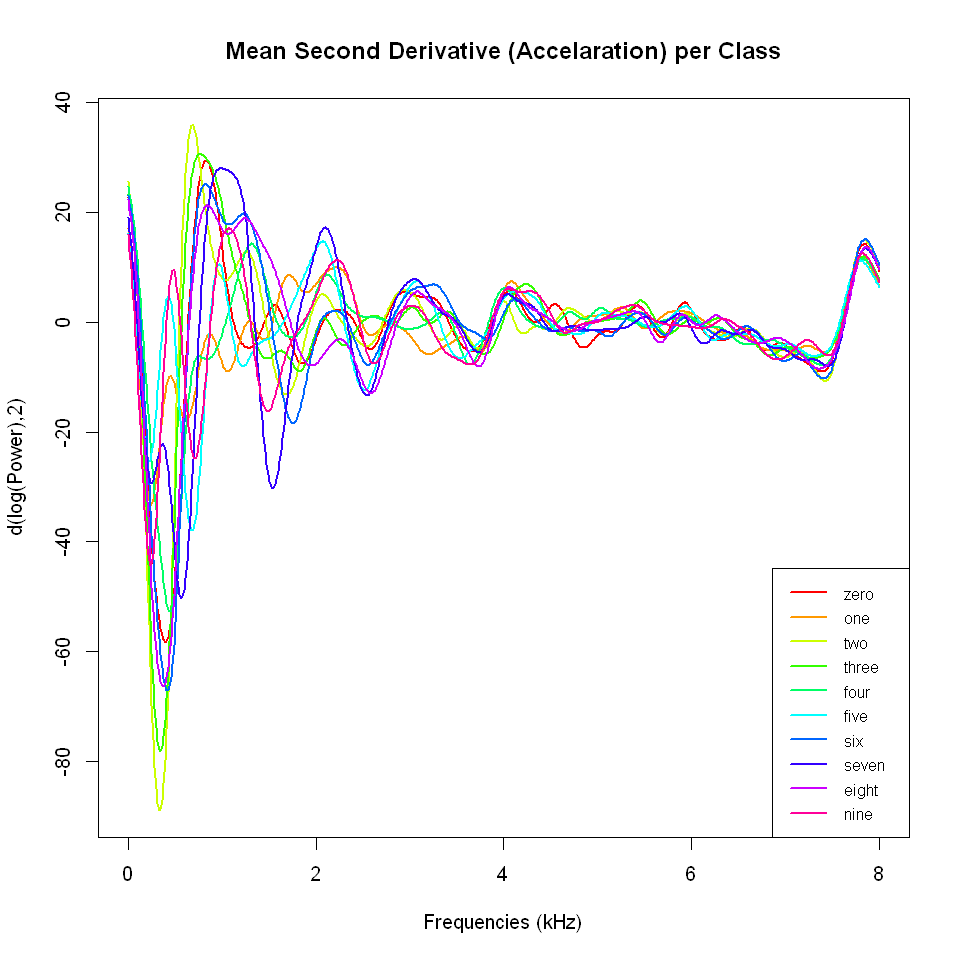

In [41]:
mean_deriv2_curves <- lapply(class_labels, function(label) {
  idx <- which(train$labels == label)
  deriv2 <- fdata.deriv(train$smooth[idx, ], nderiv = 2)
  func.mean(deriv2)
})

plot(
  mean_deriv2_curves[[1]],
  main = "Mean Second Derivative (Accelaration) per Class",
  col = palette[1],
  lwd = 2,
  # Determine a common y-axis range for all curves
  ylim = range(sapply(mean_deriv2_curves, function(x) range(x$data)))
)

for (i in 2:length(class_labels)) {
  lines(mean_deriv2_curves[[i]], col = palette[i], lwd = 2)
}

legend("bottomright", legend = class_labels, col = palette, lwd = 2, cex = 0.8)

### Covariance plots

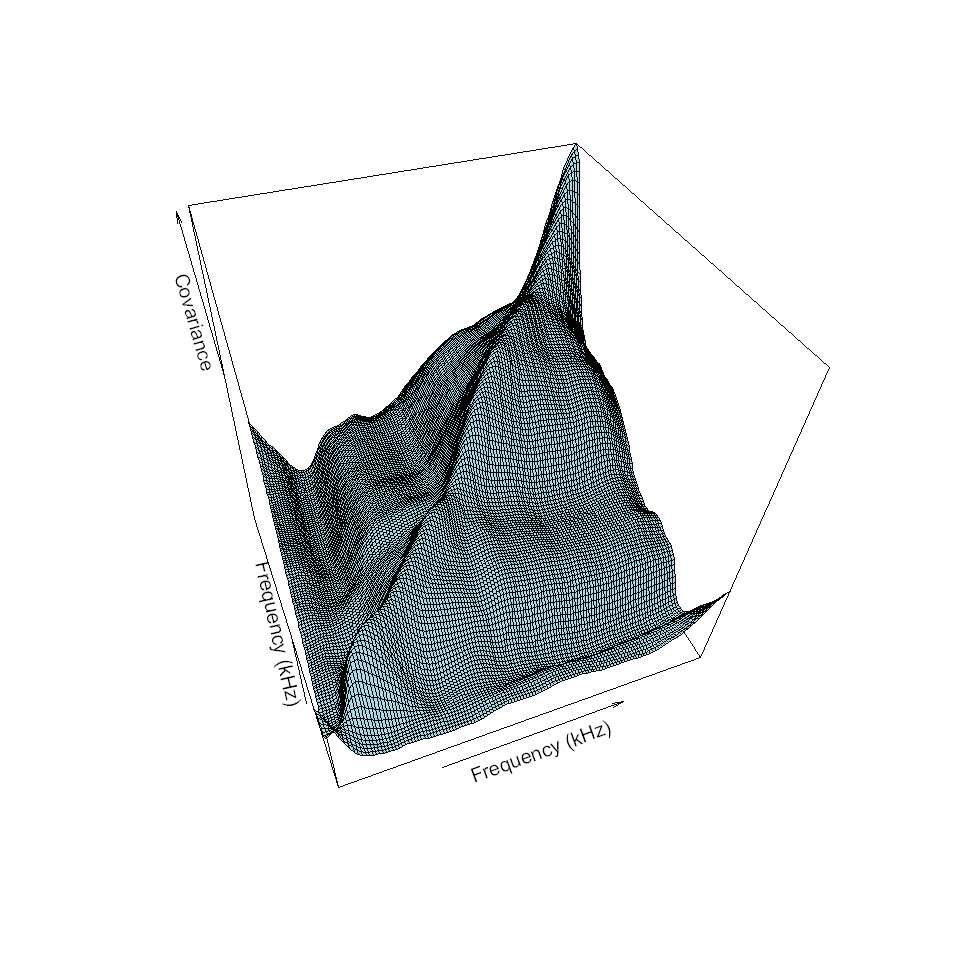

In [42]:
cov_matrix <- cov(train$smooth$data)
idx <- seq(1, ncol(cov_matrix), by = 4)
coarse_cov_matrix <- cov_matrix[idx, idx]
freqs <- train$smooth$argvals
freqs_coarse <- freqs[idx]

persp3D(
  x = freqs_coarse,
  y = freqs_coarse,
  z = coarse_cov_matrix,
  col = "lightblue", border = "black",
  xlab = "Frequency (kHz)",
  ylab = "Frequency (kHz)",
  zlab = "Covariance",
  phi = 45, theta = -20
)

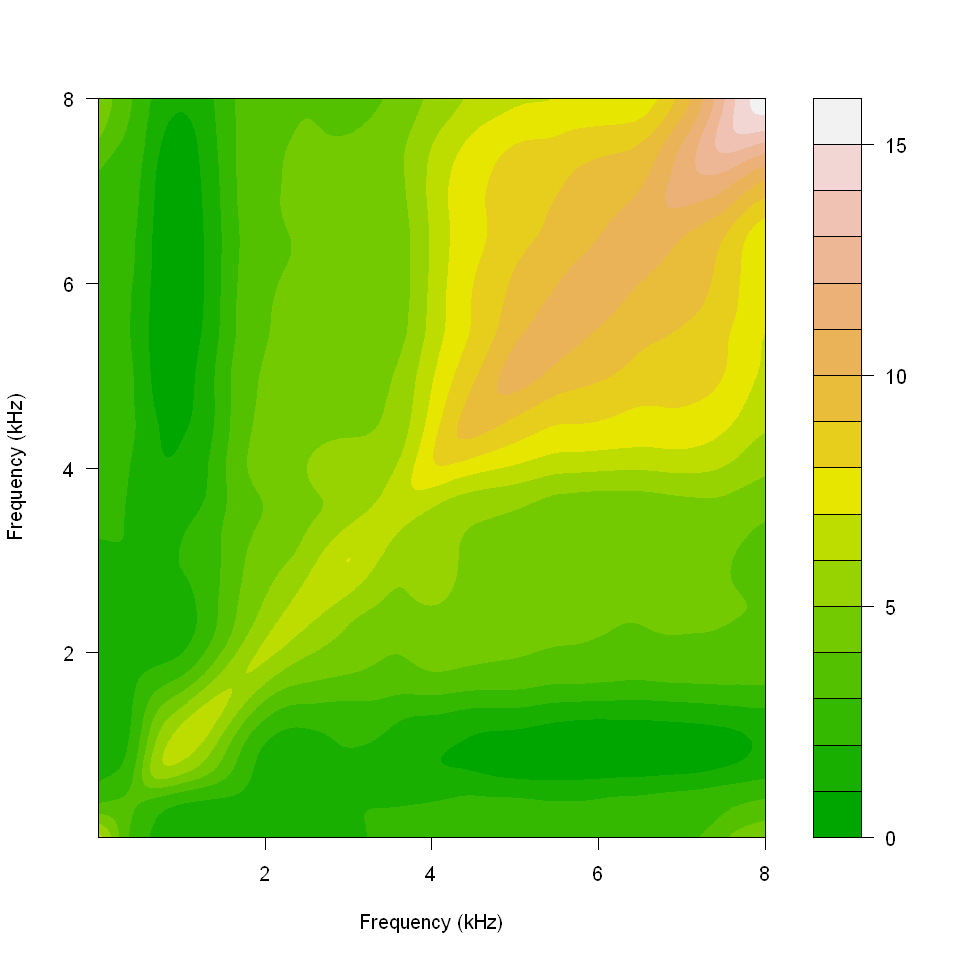

In [43]:
filled.contour(
  freqs, freqs, cov_matrix,
  color.palette = terrain.colors,
  ylab = "Frequency (kHz)",
  xlab = "Frequency (kHz)",
)

### K-means clustering

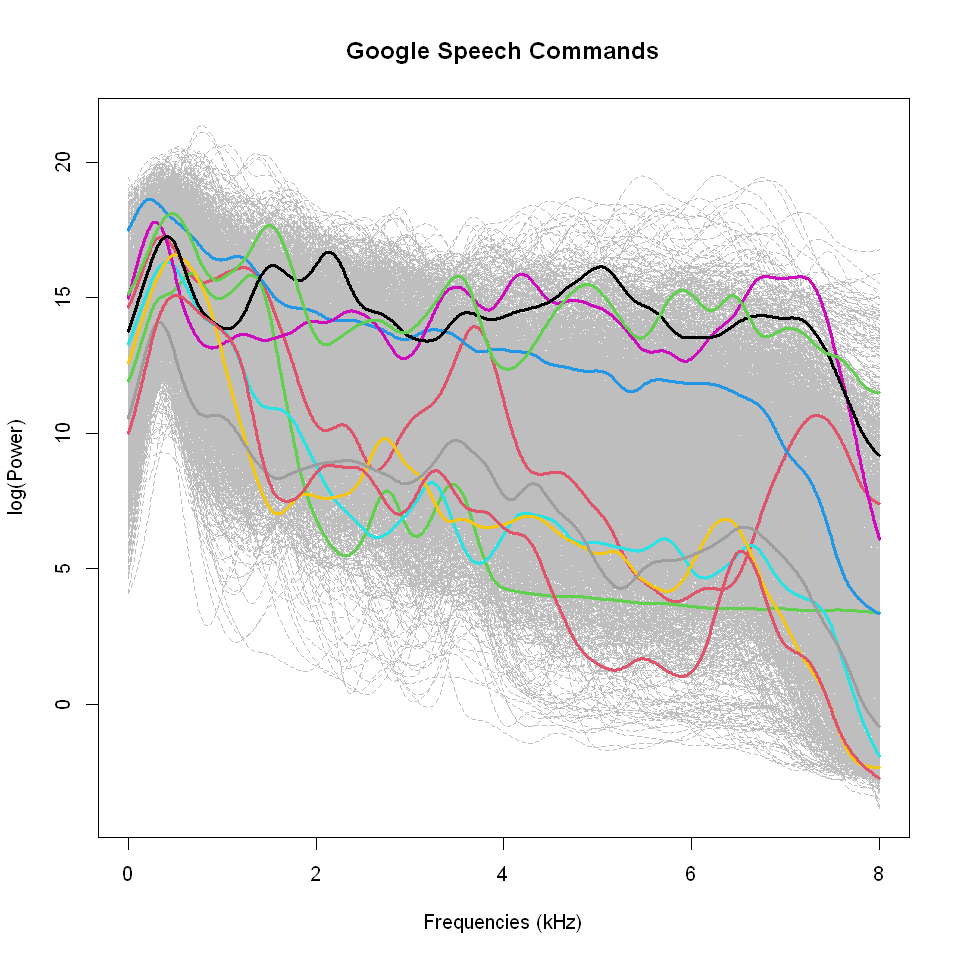

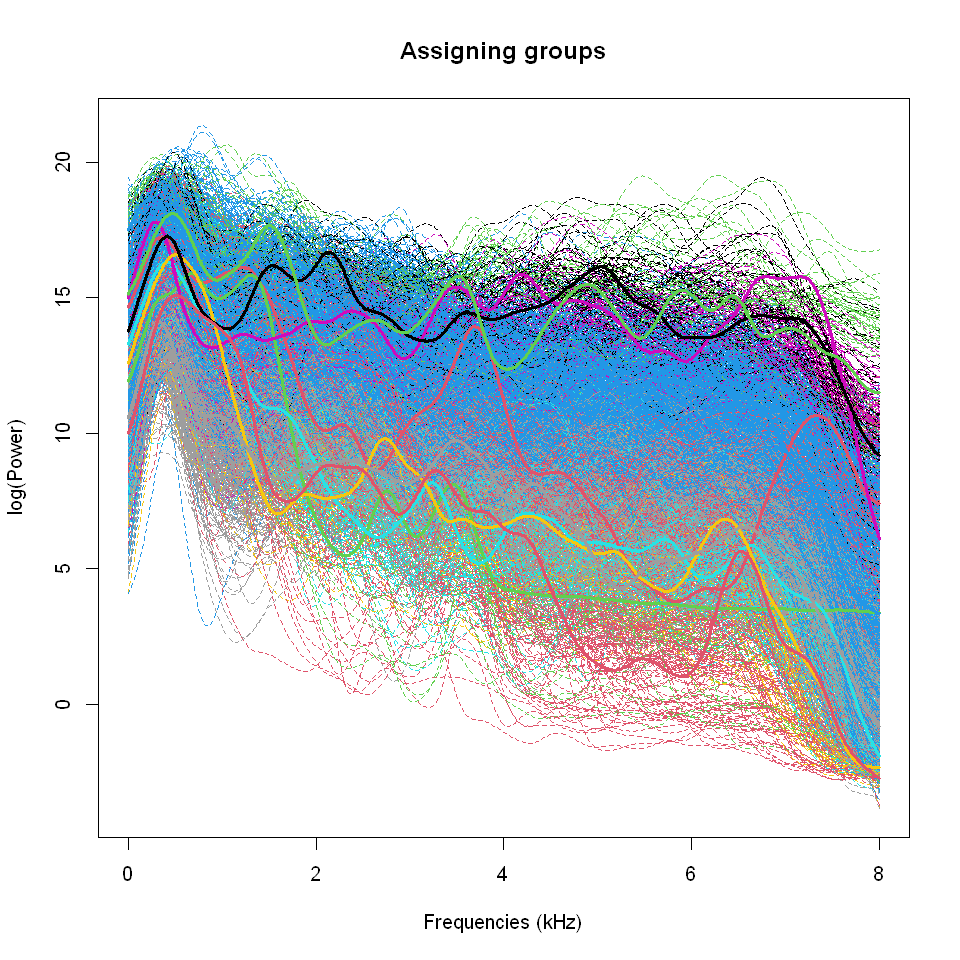

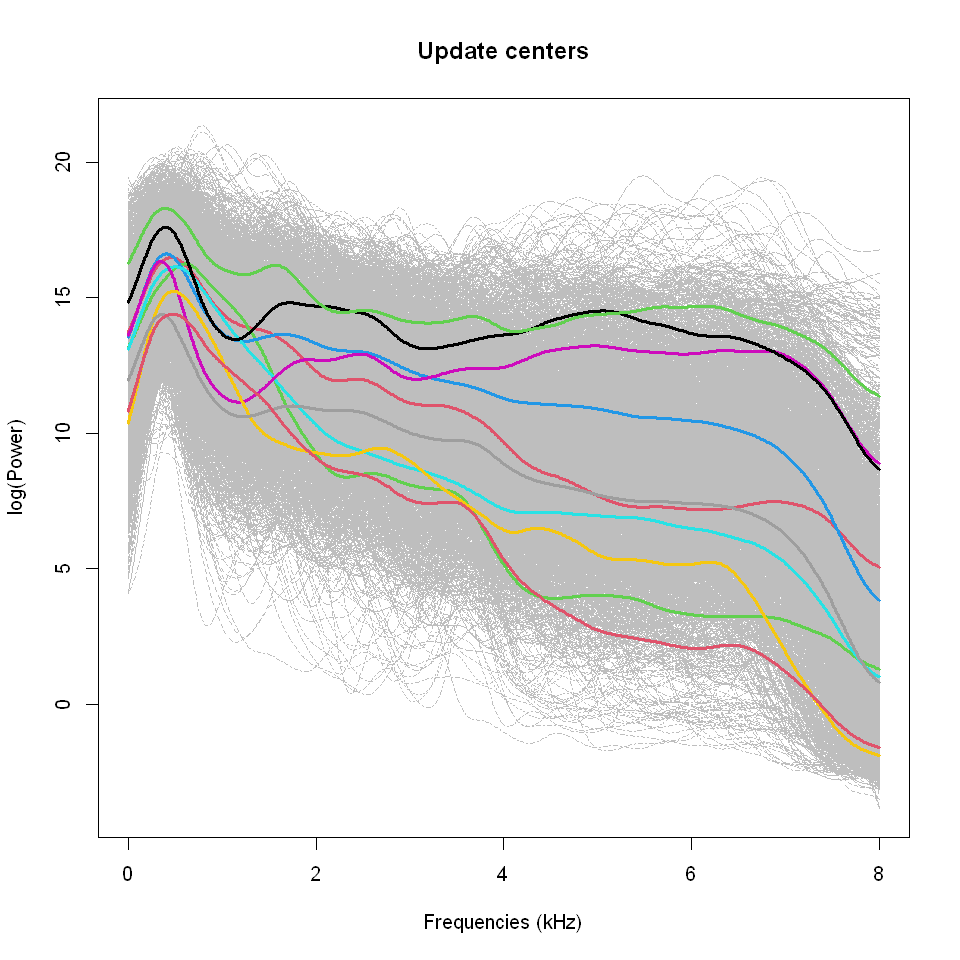

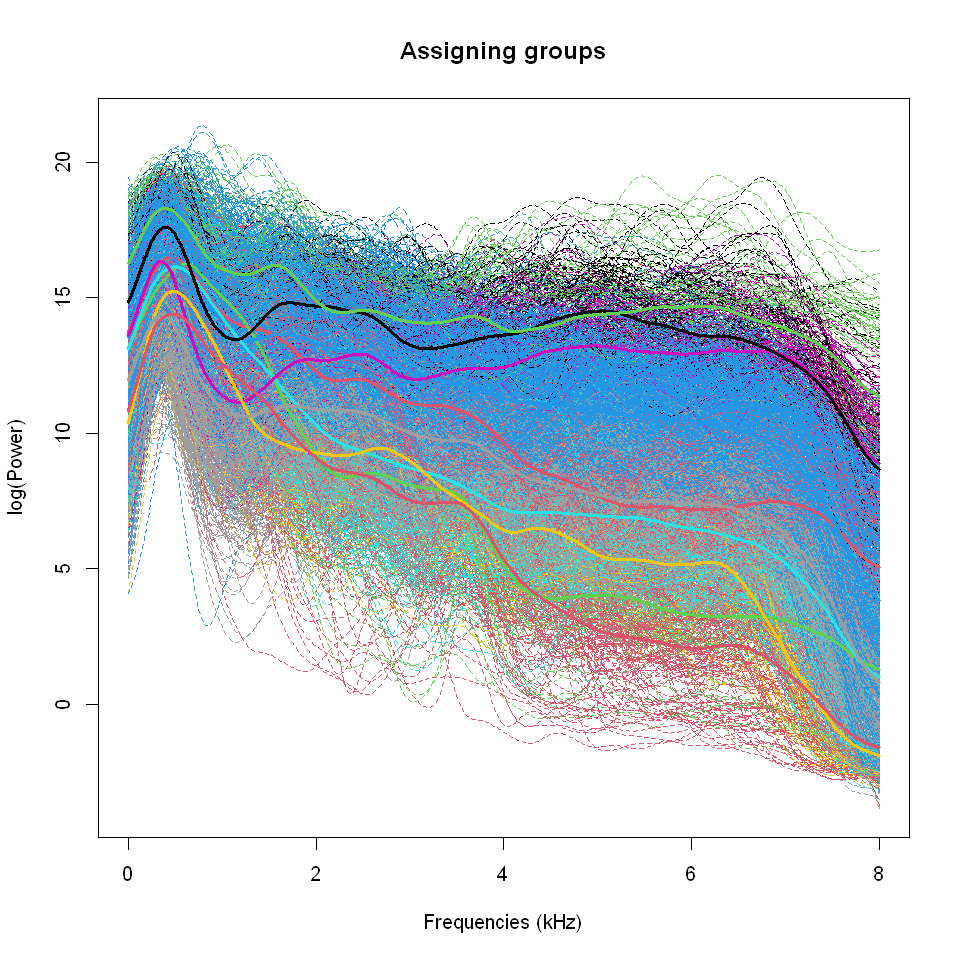

Cluster Sizes:

   1    2    3    4    5    6    7    8    9   10 
 389   60 1245  439  130   63  676  119  132   85 
Contingency Table (True Class vs Cluster):
       Cluster
True      1   2   3   4   5   6   7   8   9  10
  zero   30   3 204  16   8   3  65   9   5   9
  one    64  17  40 101   0  14  38   1  35   5
  two    31   1 136  18  23   3  88   5   7   4
  three  43   0 114  19   2   1 120   7  12   3
  four   50  19  48 143   1  17  37   1  26   5
  five   62  10 131  68   0   7  28   2  19  10
  six    10   0 157   1  71   1  52  48   2   6
  seven  27   1 165  19  12   8  50  33   2  34
  eight  13   0 142   0  13   5 125  12   4   4
  nine   59   9 108  54   0   4  73   1  20   5
Adjusted Rand Index (ARI): 0.0417


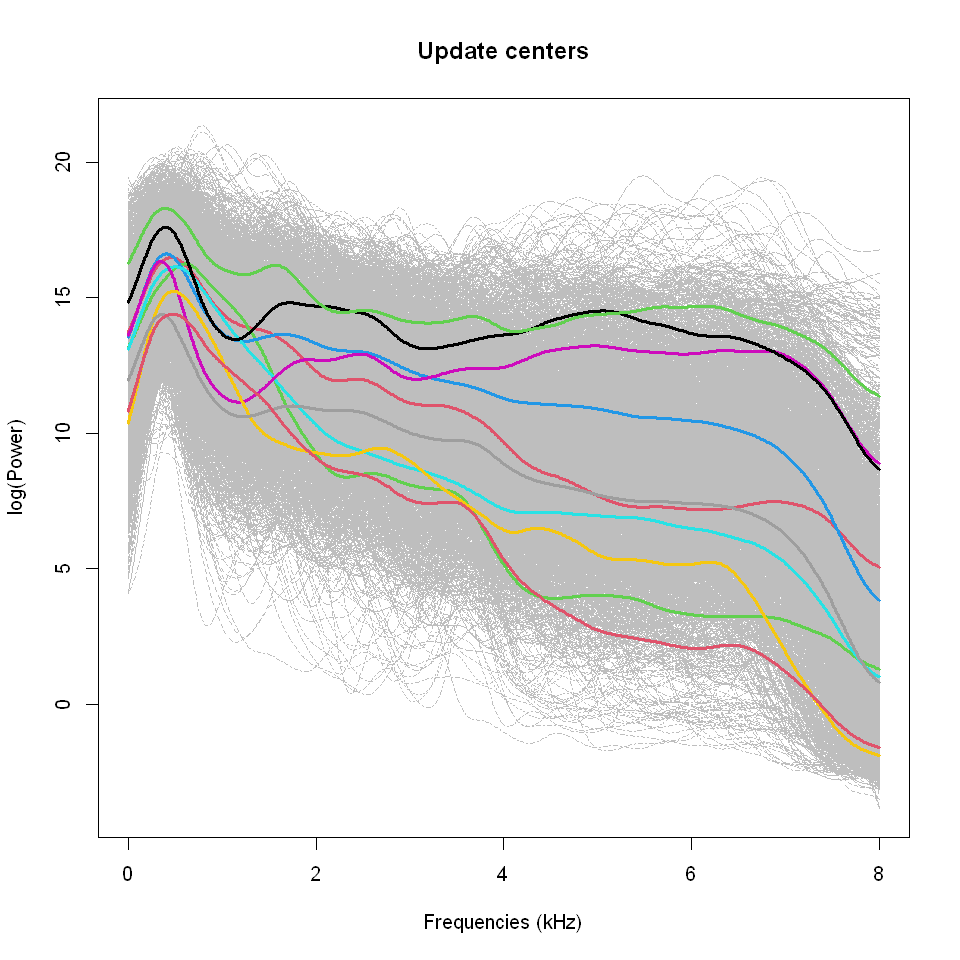

In [44]:
kmeans <- fda.usc::kmeans.fd(train$smooth, ncl = 10)
cat("Cluster Sizes:\n")
print(table(kmeans$cluster))

cat("Contingency Table (True Class vs Cluster):\n")
print(table(True = train$labels, Cluster = kmeans$cluster))

ari <- adjustedRandIndex(train$labels, kmeans$cluster)
cat(sprintf("Adjusted Rand Index (ARI): %.4f\n", ari))

### SVD

Warning message in fts(object$x, svdr[, , i]):
"Please assign column name for the data matrix."
Warning message in fts(object$x, svdr[, , i]):
"Please assign column name for the data matrix."
Warning message in fts(object$x, svdr[, , i]):
"Please assign column name for the data matrix."
Warning message in fts(object$x, svdrecon):
"Please assign column name for the data matrix."


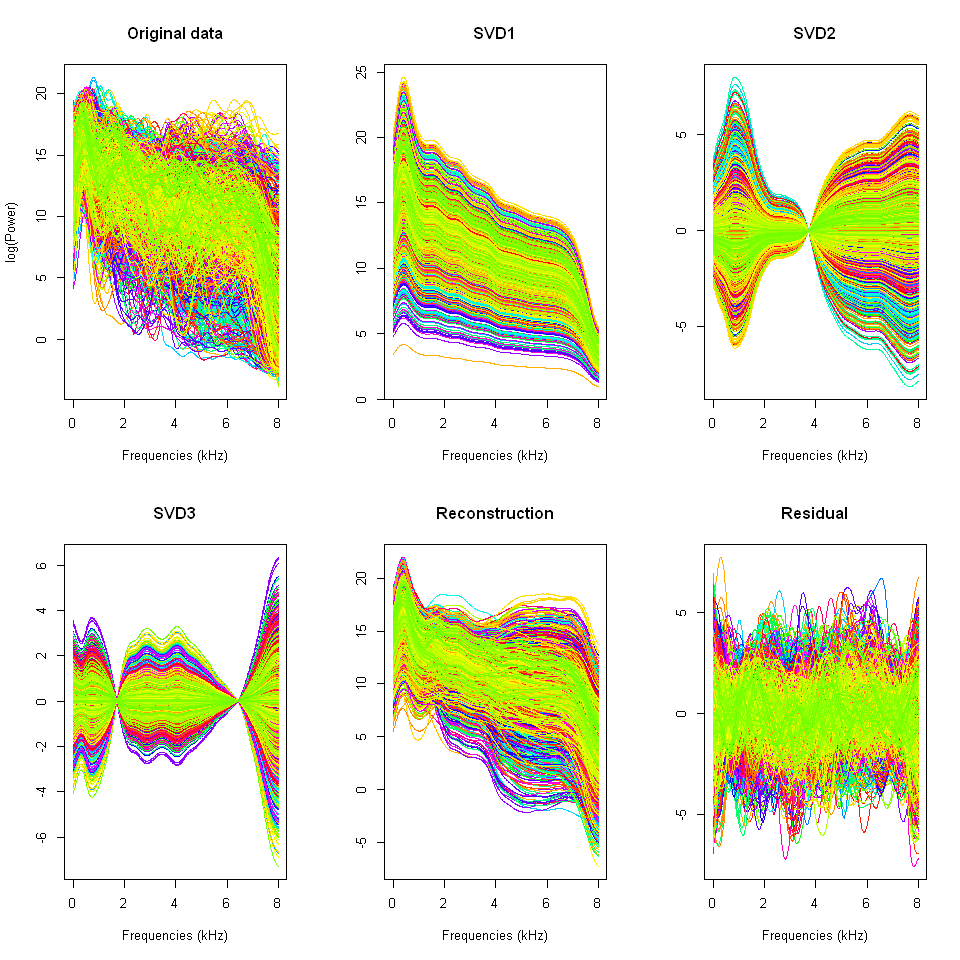

In [45]:
train$fds <- fds(
  x = train$smooth$argvals,
  y = t(train$smooth$data),
  xname = train$data$names$xlab,
  yname = train$data$names$ylab
)
SVDplot(train$fds, order = 3)

### fPCA

Number of PCs to explain at least 95% variance: 9 


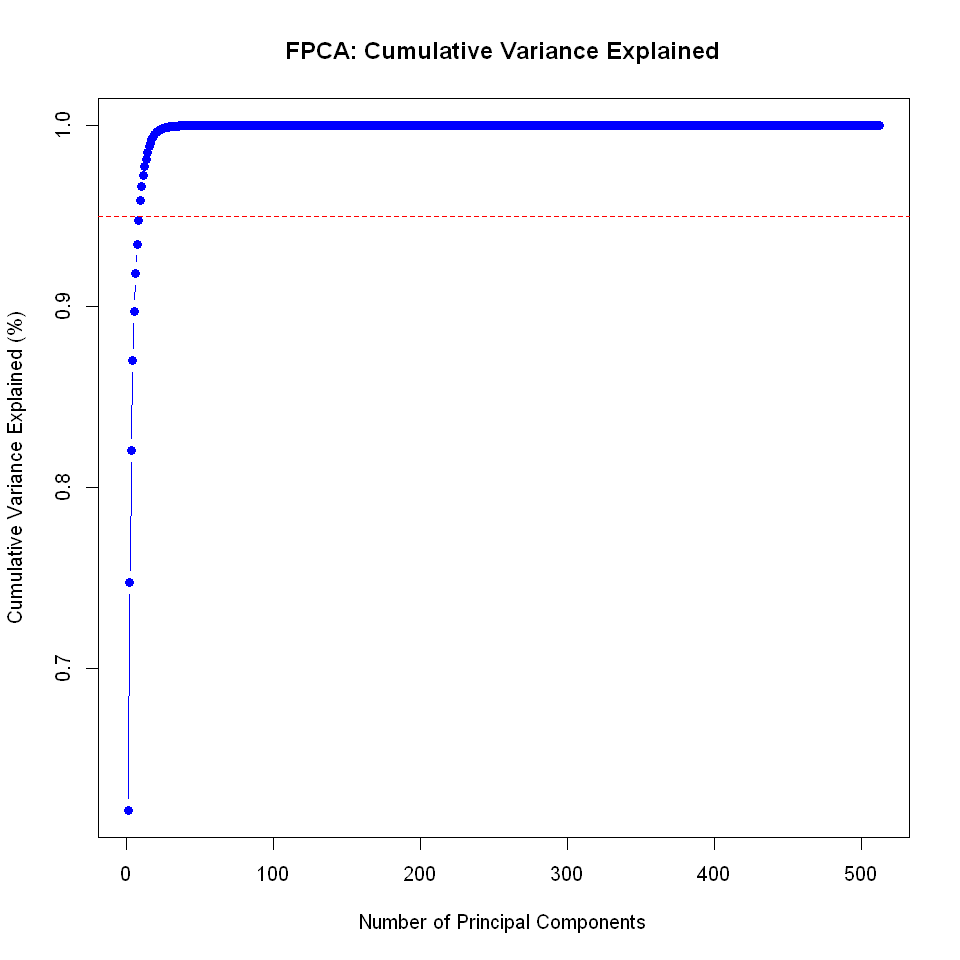

In [46]:
ncomp <- length(train$smooth$argvals)
fpca <- fdata2pc(train$smooth, ncomp = ncomp)

explained_var <- fpca$d^2 / sum(fpca$d^2)
cum_var <- cumsum(explained_var)

# Determine how many PCs explain at least 95%
top_n <- which(cum_var >= 0.95)[1]
cat("Number of PCs to explain at least 95% variance:", top_n, "\n")

options(repr.plot.width = 8, repr.plot.height = 8)
plot(
  cum_var, type = "b", pch = 19, col = "blue",
  xlab = "Number of Principal Components",
  ylab = "Cumulative Variance Explained (%)",
  main = "FPCA: Cumulative Variance Explained"
)

abline(h = 0.95, col = "red", lty = 2)

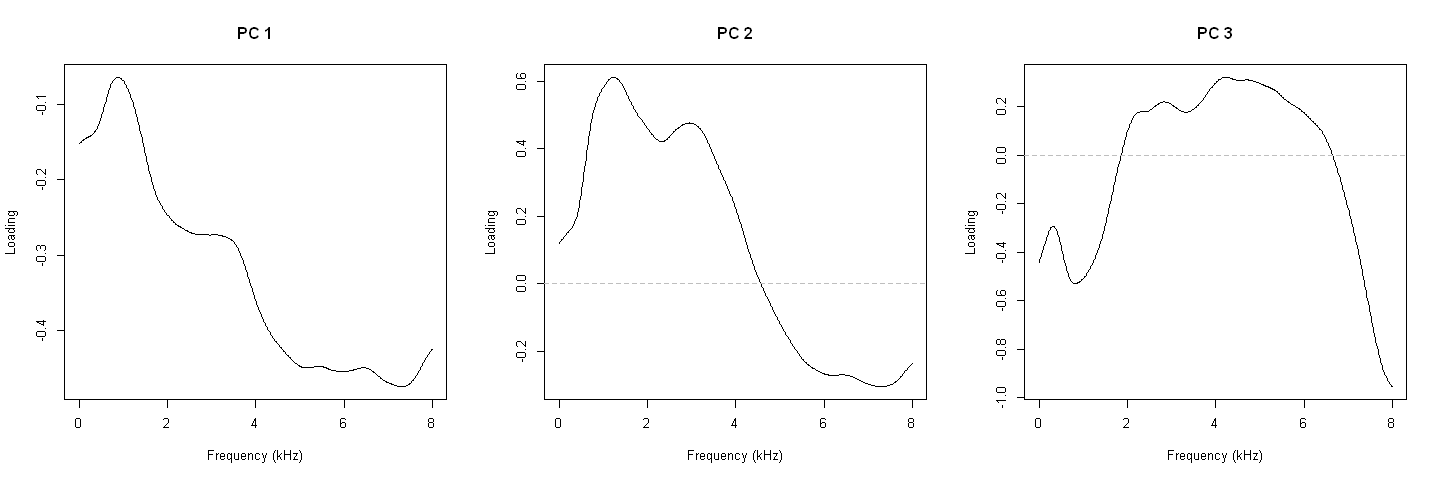

In [47]:
options(repr.plot.width = 12, repr.plot.height = 4)
layout(matrix(1:3, nrow = 1))

for (i in 1:3) {
  plot(fpca$rotation[i, ], type = "l",
       main = paste("PC", i),
       xlab = "Frequency (kHz)", ylab = "Loading")
  abline(h = 0, col = "gray", lty = 2)
}
options(repr.plot.width = 8, repr.plot.height = 8)

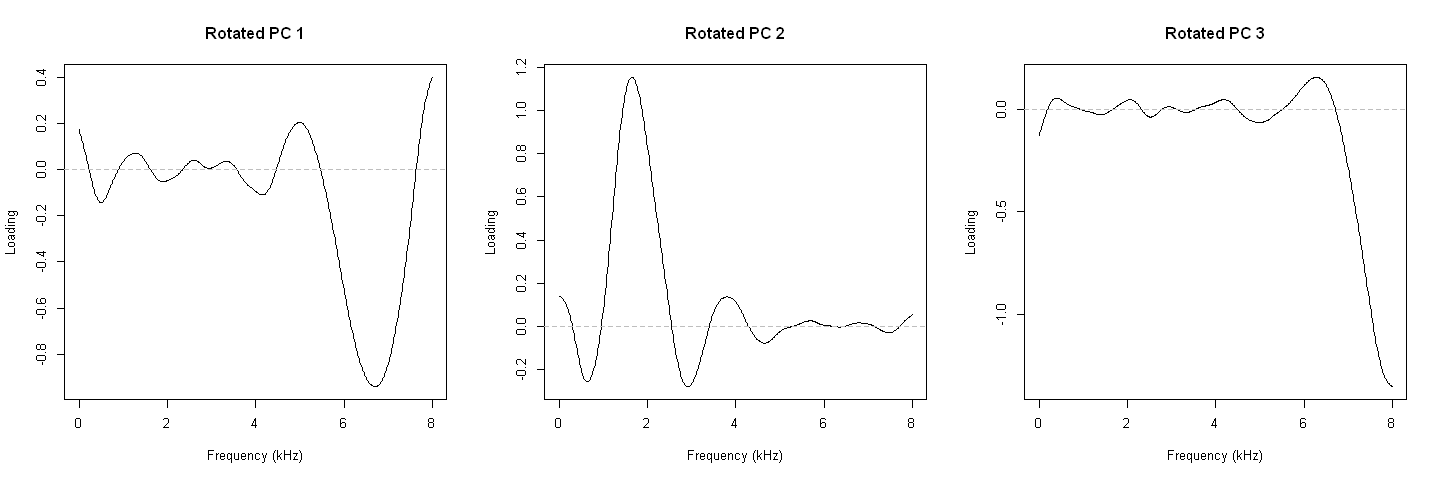

In [48]:
# Subset to top_n components
fpca$x <- fpca$x[, 1:top_n]
fpca$rotation$data <- fpca$rotation$data[1:top_n, ]

# Varimax rotation
rotated <- varimax(t(fpca$rotation$data))
fpca$rotation$data <- t(rotated$loadings)
fpca$x <- fpca$x %*% rotated$rotmat

options(repr.plot.width = 12, repr.plot.height = 4)
layout(matrix(1:3, nrow = 1))

for (i in 1:3) {
  plot(fpca$rotation[i, ], type = "l",
       main = paste("Rotated PC", i),
       xlab = "Frequency (kHz)", ylab = "Loading")
  abline(h = 0, col = "gray", lty = 2)
}
options(repr.plot.width = 8, repr.plot.height = 8)

PC1  explains: 62.17% variance
PC2  explains: 12.59% variance
PC3  explains:  7.31% variance
PC4  explains:  4.94% variance
PC5  explains:  2.72% variance
PC6  explains:  2.08% variance
PC7  explains:  1.65% variance
PC8  explains:  1.31% variance
PC9  explains:  1.10% variance


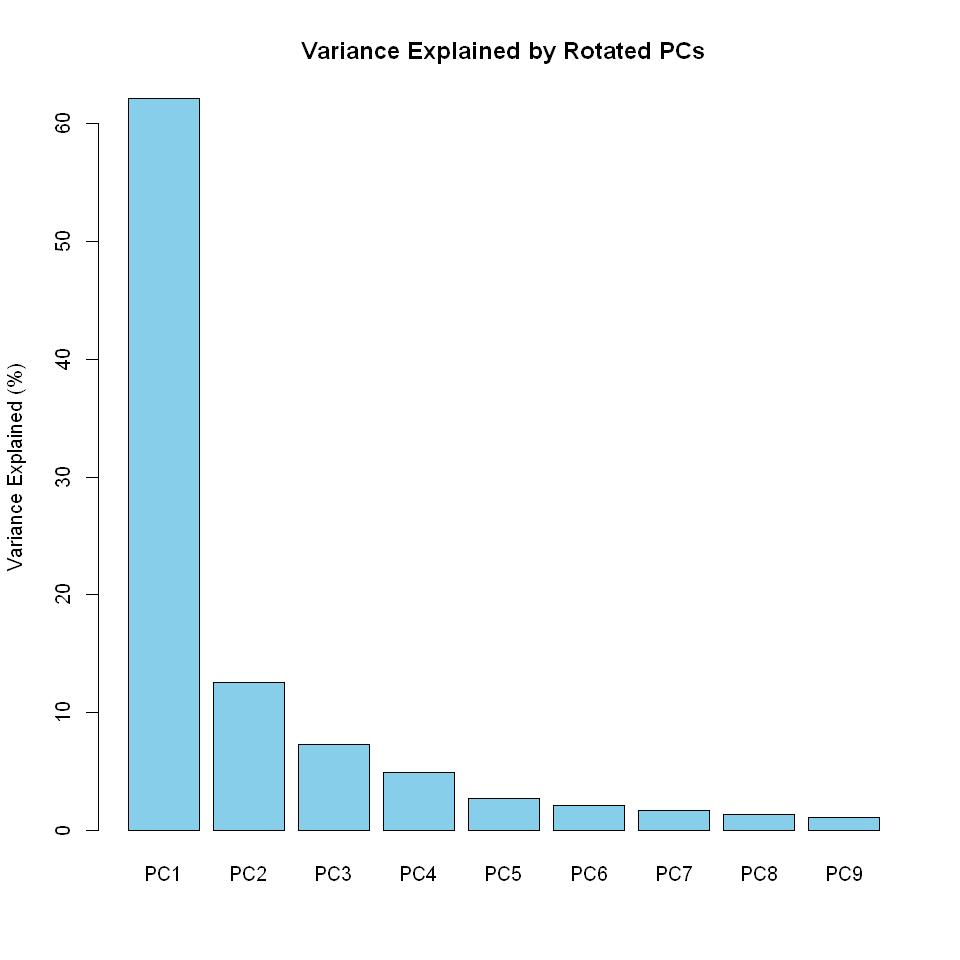

In [49]:
explained_var <- fpca$d^2 / sum(fpca$d^2)
explained_var_top <- explained_var[1:top_n]  # Only the rotated ones

for (i in 1:top_n) {
  cat(
    sprintf(
      "PC%-2d explains: %5.2f%% variance\n",
      i,
      explained_var_top[i] * 100
    )
  )
}

barplot(
  explained_var_top * 100,
  names.arg = paste0("PC", 1:top_n),
  ylab = "Variance Explained (%)",
  main = "Variance Explained by Rotated PCs",
  col = "skyblue"
)

### Classification
* Depth
* GLM
* Random Forest
* SVM
* Neural Network

In [50]:
print_metrics <- function(pred, labels) {
  cm <- caret::confusionMatrix(pred, labels)
  print(cm)

  class_stats <- cm$byClass

  macro_f1     <- mean(class_stats[, "F1"])
  macro_prec   <- mean(class_stats[, "Precision"])
  macro_recall <- mean(class_stats[, "Recall"])

  cat(sprintf("Macro Precision: %.3f\n", macro_prec))
  cat(sprintf("Macro Recall:    %.3f\n", macro_recall))
  cat(sprintf("Macro F1-score:  %.3f\n", macro_f1))

  cat("\nPer-class metrics:\n")
  print(class_stats[, c("Precision", "Recall", "F1")])
}

train_data_list <- ldata(
  "df" = data.frame(y = train$labels),
  "x"  = train$smooth
)
test_data_list <- list("x" = test$smooth)

In [51]:
depth_fit <- classif.depth(
  group = train$labels,
  fdataobj = train$data,
  newfdataobj = test$data,
  depth = "FM"
)
print_metrics(depth_fit$group.pred, test$labels)

Confusion Matrix and Statistics

          Reference
Prediction zero one two three four five six seven eight nine
     zero    55   9  23    28   15   48   9    20     4   15
     one      7 127  31    51   49   47   1     8    37   82
     two     30   9  81    34   27    7  41    27    31    5
     three   20   3  31    82    0    4   6     9    29   10
     four    45  75  49    41  172   54  11    38    15   37
     five    16  83   7     3   26   98   0     4     0   69
     six     84   5  78    40   15   22 229   111    65   12
     seven  104  21  47    37   55   75  59   144    34   33
     eight   16  11  27    45    7   29  18     9   146   41
     nine     8  21  10    16    2   24   0     6    15   73

Overall Statistics
                                          
               Accuracy : 0.3186          
                 95% CI : (0.3037, 0.3337)
    No Information Rate : 0.1077          
    P-Value [Acc > NIR] : < 2.2e-16       
                                         

In [61]:
glm_fit <- classif.glm(
  # formula: y is the response, x is the functional covariate
  y ~ x,
  data = train_data_list,
  family = binomial(),  # multinomial families are handled automatically
  type = "1vsall"       # multiclass
)

glm_pred <- predict(glm_fit, test_data_list)
print_metrics(glm_pred, test$labels)

Confusion Matrix and Statistics

          Reference
Prediction zero one two three four five six seven eight nine
     zero    57  13  21    31    8   13  14    41    15   37
     one      2 113  21     2   23   39   0     4     2   29
     two     33   5  84    45   17    2  28    19    44    6
     three   39   3  48   140    6    9  30    16    74   47
     four    34  81  37     8  239   62   2    44     3   26
     five    34  74   4     5   38  196   0    13     0   53
     six     41   1  51    21    4    1 236    43    26    2
     seven   98   6  27     8   18   26  37   173     4    9
     eight   26   0  69    72    1    0  22     3   202    5
     nine    21  68  22    45   14   60   5    20     6  163

Overall Statistics
                                         
               Accuracy : 0.4231         
                 95% CI : (0.4073, 0.439)
    No Information Rate : 0.1077         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
    

In [86]:
rf_fit <- classif.randomForest(
  y ~ x,
  data  = train_data_list,
  ntree = 150,
)
rf_pred <- predict(rf_fit, test_data_list)
print_metrics(rf_pred, test$labels)

Confusion Matrix and Statistics

          Reference
Prediction zero one two three four five six seven eight nine
     zero    73  24  40    43   26   28  33    61    21   33
     one     14 102  23    22   39   38   1    12    14   54
     two     18   3  61    27    8    3  26    15    45    1
     three   26  18  41    86    4   13   6    14    67   35
     four    23  55  36    21  187   40   2    31     3   15
     five    37  75   9    15   40  178   2    24     1   80
     six     48   0  77    26   11    6 234    62    58    5
     seven  103   8  32    28   39   36  42   145    15   16
     eight   16   1  46    58    4    3  23     4   136   10
     nine    27  78  19    51   10   63   5     8    16  128

Overall Statistics
                                          
               Accuracy : 0.351           
                 95% CI : (0.3358, 0.3665)
    No Information Rate : 0.1077          
    P-Value [Acc > NIR] : < 2.2e-16       
                                         

In [54]:
svm_fit <- classif.svm(y ~ x, data = train_data_list)
svm_pred <- predict(svm_fit, test_data_list)
print_metrics(svm_pred, test$labels)

Confusion Matrix and Statistics

          Reference
Prediction zero one two three four five six seven eight nine
     zero    56  13  25    45   14   26  22    52    21   35
     one     28 166  49    21   57   70   2    24     4   72
     two     47   7 102    60   30   11  48    33    53   15
     three   30  12  24    97    2    9  13    20    49   54
     four     9  32  15     7  148   23   0    12     2    7
     five    41  96   7     9   45  220   1    31     0   78
     six     34   0  45    17    5    2 217    34    33    0
     seven   92   6  24     6   60   23  46   160     2    8
     eight   20   0  82    81    3    0  21     2   203   10
     nine    28  32  11    34    4   24   4     8     9   98

Overall Statistics
                                          
               Accuracy : 0.3872          
                 95% CI : (0.3716, 0.4029)
    No Information Rate : 0.1077          
    P-Value [Acc > NIR] : < 2.2e-16       
                                         

In [55]:
nnet_fit <- classif.nnet(y ~ x, data = train_data_list, size = 10, maxit = 100)
nnet_pred <- predict(nnet_fit, test_data_list)
print_metrics(nnet_pred, test$labels)

# weights:  190
initial  value 8079.748193 
iter  10 value 6174.528493
iter  20 value 5665.919740
iter  30 value 5266.497767
iter  40 value 5052.474656
iter  50 value 4899.330545
iter  60 value 4828.611091
iter  70 value 4784.487315
iter  80 value 4761.439885
iter  90 value 4733.142882
iter 100 value 4715.210525
final  value 4715.210525 
stopped after 100 iterations
Confusion Matrix and Statistics

          Reference
Prediction zero one two three four five six seven eight nine
     zero    41   7  17    33    4   15  20    36    12   19
     one      8 114  30     4   31   38   0     7     2   39
     two     22   4  91    31   19    2  27     9    70    2
     three   34   4  43   131    0    3  13    11    63   29
     four    28  87  33     5  215   69   2    30     3   24
     five    31  94   7     6   45  194   0    21     1   66
     six     38   0  49    25    2    0 240    47    35    2
     seven  137   4  38    18   40   25  46   194     8   12
     eight   19   0  54    74